In [31]:
%matplotlib inline

import json
import datetime
import sys

import numpy as np
import pandas as pd
from pandas_datareader import data, wb
import seaborn as sns
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import metrics

sys.path.append("../")
import utils.load_data as ld

## import

Get greatest market losses over the next X days for each date

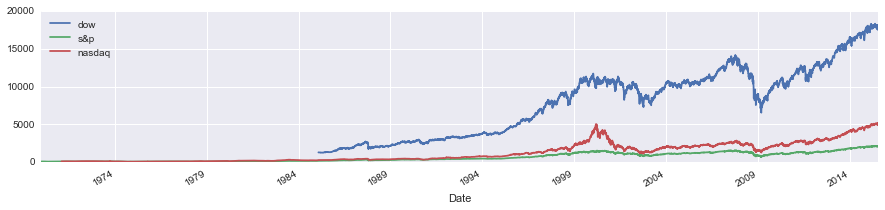

In [2]:
market = ld.latest_csv_to_pandas('market')
market.columns = ['dow', 's&p', 'nasdaq']
market.plot(figsize=[15,3])

In [3]:
# create df of lagged returns
ticker = 's&p'
px = pd.DataFrame(data=market[ticker].values, 
                  columns=[0,], 
                  index=market[ticker].index)
for i in range(1, 180):
    px[i] = px[0].shift(-1 * i)
ret = (px.div(px[0], axis='index')
       .applymap(lambda x: x - 1.))

In [4]:
# create triangle mask to find max losses over a period of time
def get_max_drop(per, ret):
    """Given a dataframe of increasingly lagged returns in each column, 
    find the largest negative return between the first date in index and `per` periods in the future.

    :param per: An integer specifying number periods into future to consider
    :param per: A data frame of returns and lagged returns for each date
    :rtype: A float
    """
    m = np.ones([per,per],dtype='bool')
    m[np.triu_indices(per)] = False
    m = np.fliplr(m)
    return ret.ix[:per,1:per].mask(m).min().min()   

In [5]:
# build df of max losses over multiple ranges
drops = {}
for months in (1,3,6):
    per = 22 * months 
    drops[months] = pd.Series(data=[get_max_drop(per, ret.ix[i:,:]) for i in range(0,ret.shape[0]-per)],
                              index=ret.index[:ret.shape[0]-per])
drops = pd.DataFrame(drops)

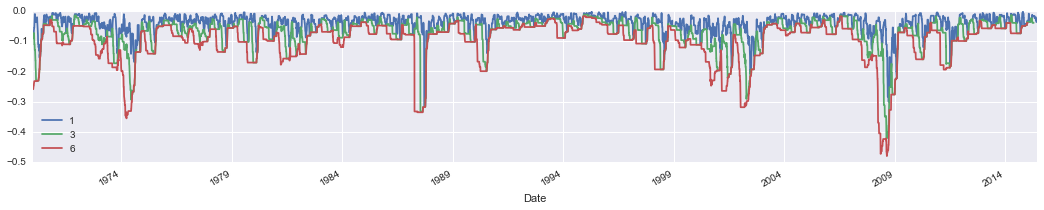

In [6]:
drops.plot(figsize=[18,3])

Import FRED data

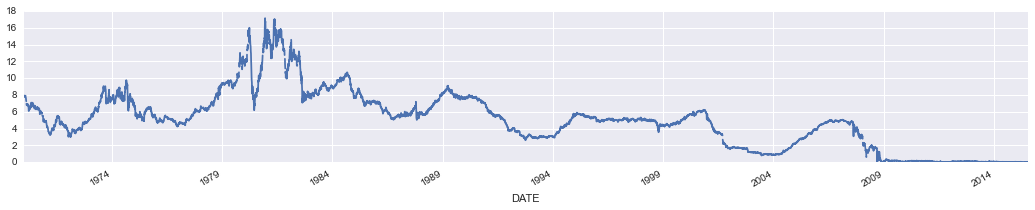

In [7]:
fred = ld.latest_csv_to_pandas('fred')
fred["DTB3"].plot(figsize=[18,3])

Import scraped multipl data

In [8]:
multipl = ld.latest_multipl_json_to_pandas()

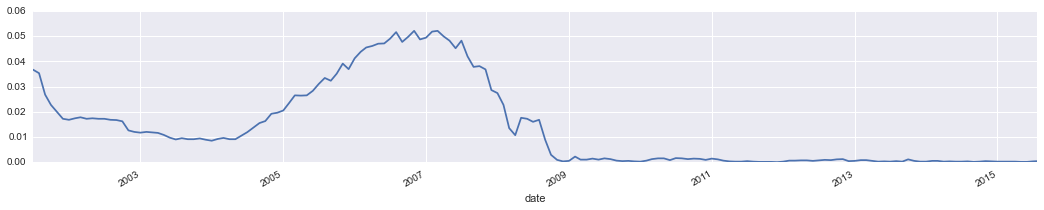

In [9]:
multipl['1 Month Treasury Rate'].dropna().plot(figsize=[18,3])

## consolidate

In [10]:
start = datetime.datetime(1970, 1, 1)
def generalize(df):
    df = df.resample('d', fill_method='ffill')
    df.index.name = 'date'
    df = df.ix[start:]
    return df
market = generalize(market)
fred = generalize(fred)
multipl = generalize(multipl)
ag = multipl.join(market.join(fred))

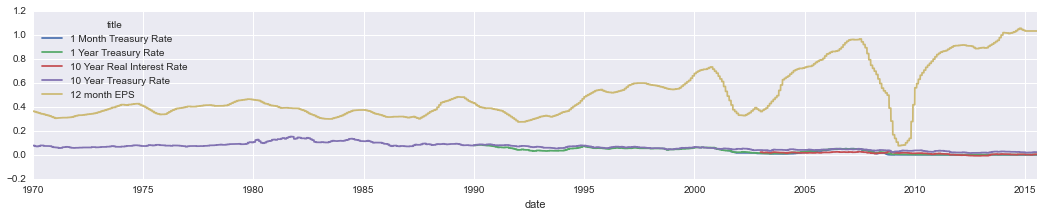

In [11]:
ag.ix[:,:5].plot(figsize=[18,3])

In [12]:
print ag.columns

Index([                u'1 Month Treasury Rate',
                        u'1 Year Treasury Rate',
                  u'10 Year Real Interest Rate',
                       u'10 Year Treasury Rate',
                                u'12 month EPS',
                        u'2 Year Treasury Rate',
                  u'20 Year Real Interest Rate',
                       u'20 Year Treasury Rate',
                       u'3 Month Treasury Rate',
                        u'3 Year Treasury Rate',
                  u'30 Year Real Interest Rate',
                       u'30 Year Treasury Rate',
                   u'5 Year Real Interest Rate',
                        u'5 Year Treasury Rate',
                       u'6 Month Treasury Rate',
                   u'7 Year Real Interest Rate',
                        u'7 Year Treasury Rate',
                                         u'CPI',
                                u'Debt Percent',
                                u'GDP Deflator',
                    

## basic model

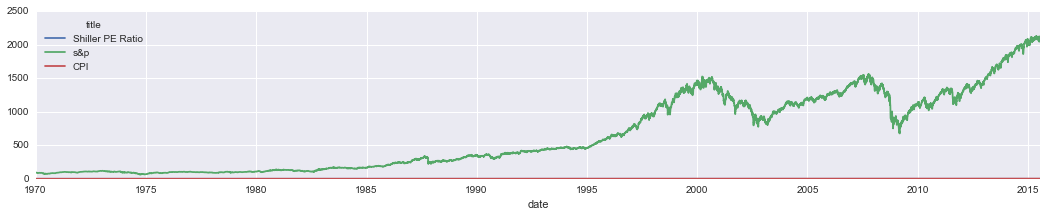

In [13]:
cols = ['Shiller PE Ratio', 's&p', 'CPI']
exp = ag[cols].copy(deep=True)
exp.plot(figsize=[18,3])

In [14]:
# get YoY changes
for i in ('s&p', 'CPI'):
    exp[i] = pd.ewma(exp[i], halflife=180)
    exp[i] = exp[i] / exp[i].shift(360) - 1.

In [15]:
# time series score
avg = pd.ewma(exp, halflife=720, min_periods=360)
std = pd.ewmstd(exp, halflife=720, min_periods=360)
scores = (((exp - avg) / std)
          .dropna(axis=0, how='any'))

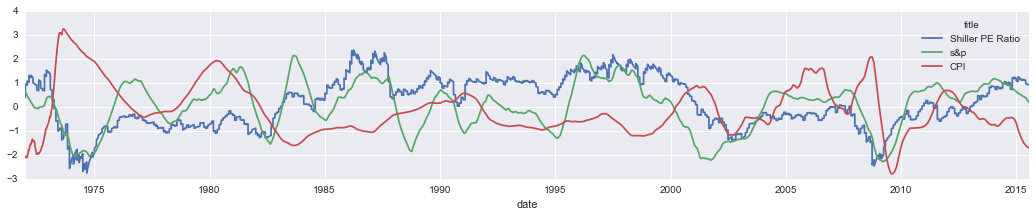

In [16]:
scores.plot(figsize=[18,3])

Run logistic regression

In [131]:
thresh = -.2
y = drops[6].dropna().map(lambda x: 1 if x < thresh else 0)
X = scores.ix[y.index].dropna(axis=0, how='all')
y = y.ix[X.index]

In [132]:
# make set of 1s and 0s roughly even
hits = y[y==1]
hit_rows = X.ix[hits.index]

hit_ratio = (y.sum() * 1.) / y.count()
for i in range(int(1 / hit_ratio)):
    X = X.append(hit_rows)
    y = y.append(hits)

In [135]:
(X_train, X_test, 
 y_train, y_test) = cross_validation.train_test_split(X, 
                                                      y, 
                                                      test_size=0.4, 
                                                      random_state=0)

In [136]:
clf = linear_model.LogisticRegression(penalty="l2", C=1)
clf.fit (X_train.values, y_train.values)
y_pred = clf.predict(X_test)
print clf.coef_
print clf.score(X_test, y_test)
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), 
             index=['0 - actual', '1 - actual'], 
             columns=['0 - predicted', '1 - predicted'])

[[ 0.64707281 -1.26954999  0.718221  ]]
0.790243331774


,0 - predicted,1 - predicted
0 - actual,3219,755
1 - actual,1038,3536
